In [35]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

data_anly= pd.read_csv('data/data_cal.csv')

## 数据列描述
- Measured & Upscaled	测量值
- Most recent forecast 最近一个点的预测值
- Monitored capacity	运行容量
- ShiftMeasured 测量值往后平移一个点（用于在同一行进行波动值计算）
- Fluctuation15M 15分钟波动值
- PredFluctuation15M 预测值的15分钟波动值
- ShiftFluctuation15M 后移15分钟波动值（用于分析连续两次波动）


In [36]:
data_anly['abs_Fluctuation15M'] = abs(data_anly['Fluctuation15M'])
data_anly['above_line'] = data_anly['abs_Fluctuation15M'] - 50 
data_anly

,Datetime,Measured & Upscaled,Most recent forecast,Monitored capacity,ShiftMeasured,Fluctuation15M,PredFluctuation15M,ShiftFluctuation15M,abs_Fluctuation15M,above_line
0,2022-01-01 00:00:00,1803.48,1881.52,2254.4,1803.48,0.00,78.04,0.00,0.00,-50.00
1,2022-01-01 00:15:00,1962.39,1855.50,2254.4,1803.48,158.91,52.02,0.00,158.91,108.91
2,2022-01-01 00:30:00,1801.63,1823.16,2254.4,1962.39,-160.76,-139.23,158.91,160.76,110.76
3,2022-01-01 00:45:00,1824.41,1795.96,2254.4,1801.63,22.78,-5.67,-160.76,22.78,-27.22
4,2022-01-01 01:00:00,1661.57,1779.28,2254.4,1824.41,-162.84,-45.13,22.78,162.84,112.84
...,...,...,...,...,...,...,...,...,...,...
35035,2022-12-31 22:45:00,2187.05,2133.89,2254.4,2177.33,9.72,-43.44,16.48,9.72,-40.28
35036,2022-12-31 23:00:00,2177.68,2123.49,2254.4,2187.05,-9.37,-63.56,9.72,9.37,-40.63
35037,2022-12-31 23:15:00,2180.85,2129.58,2254.4,2177.68,3.17,-48.10,-9.37,3.17,-46.83
35038,2022-12-31 23:30:00,2177.87,2147.49,2254.4,2180.85,-2.98,-33.36,3.17,2.98,-47.02


In [37]:
# data_anly[data_anly['Fluctuation15M']*data_anly['PredFluctuation15M']>0]

- 第一步，总体描述观察，对数据进行一个总体的描述
- 第二步，对数据超出考核范围的进行描述（必要性）
- 第三步，对数据类型进行分类
-       一上一下（时移性；可行性：一上一下有多少，的差值有多大）
-       多上or多下（考虑配储空间的必要性）
-       多上的情况分布如何
-       多上的情况功率求和值为多大（加起来超过储能容量的有多少）（考虑配储空间的必要性）
- 第四步，对之前的结果进行季节性分类分析
    （来说明现象出现的普适性，以及季节出现不同的差别）

# 第一章，总体描述

In [38]:

data_anly.describe().to_csv('ch2_data/计算数据总体描述.csv')
data_anly.describe()

,Measured & Upscaled,Most recent forecast,Monitored capacity,ShiftMeasured,Fluctuation15M,PredFluctuation15M,ShiftFluctuation15M,abs_Fluctuation15M,above_line
count,35040.000000,35040.000000,3.504000e+04,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,758.354345,957.642837,2.254400e+03,758.344110,0.010235,199.299546,0.010685,40.860348,-9.139652
std,774.366215,771.504146,3.183277e-12,774.350031,75.455406,266.444217,75.455359,63.434239,63.434239
min,-8.530000,0.000000,2.254400e+03,-8.530000,-1142.340000,-1285.080000,-1142.340000,0.000000,-50.000000
25%,89.880000,243.040000,2.254400e+03,89.880000,-18.870000,10.457500,-18.870000,4.490000,-45.510000
50%,437.150000,775.880000,2.254400e+03,437.150000,-0.070000,126.420000,-0.070000,18.230000,-31.770000
75%,1406.982500,1726.882500,2.254400e+03,1406.982500,17.510000,334.495000,17.510000,50.850000,0.850000
max,2240.910000,2166.880000,2.254400e+03,2240.910000,1284.680000,1773.830000,1284.680000,1284.680000,1234.680000


In [39]:
data_anly[data_anly['abs_Fluctuation15M']>50].describe()


,Measured & Upscaled,Most recent forecast,Monitored capacity,ShiftMeasured,Fluctuation15M,PredFluctuation15M,ShiftFluctuation15M,abs_Fluctuation15M,above_line
count,8903.000000,8903.000000,8.903000e+03,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000
mean,1072.380850,1334.945249,2.254400e+03,1070.701174,1.679677,264.244075,2.244650,118.516588,68.516588
std,607.636584,593.399779,2.501251e-11,608.488811,145.741190,305.747311,126.549375,84.826628,84.826628
min,-4.890000,0.000000,2.254400e+03,-5.310000,-1142.340000,-1285.080000,-823.630000,50.010000,0.010000
25%,545.200000,841.480000,2.254400e+03,543.450000,-90.035000,57.010000,-61.085000,66.730000,16.730000
50%,990.680000,1403.620000,2.254400e+03,989.300000,50.150000,231.490000,0.710000,90.800000,40.800000
75%,1617.185000,1878.620000,2.254400e+03,1619.955000,91.635000,444.155000,65.790000,137.960000,87.960000
max,2225.930000,2166.880000,2.254400e+03,2232.780000,1284.680000,1768.990000,1284.680000,1284.680000,1234.680000


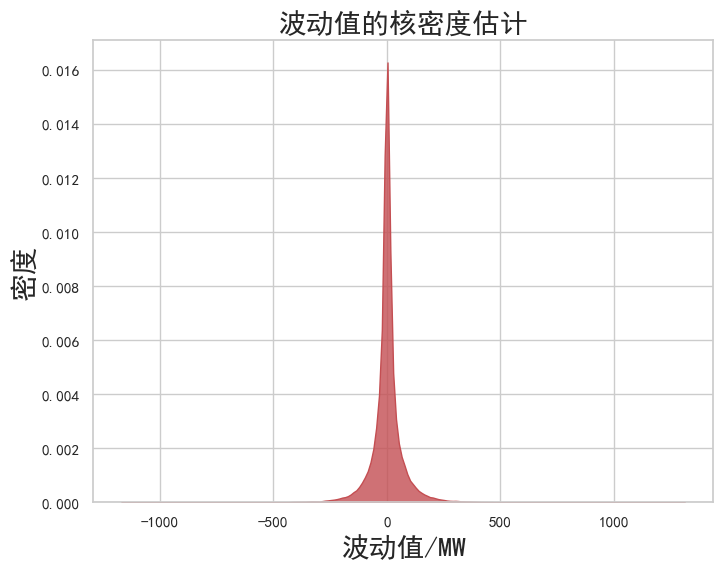

In [40]:
# data_anly['Fluctuation15M'].plot (kind='kde')


# 设置图形风格
sns.set(style="whitegrid")

# 绘制核密度估计图
plt.figure(figsize=(8, 6))
sns.kdeplot(data_anly['Fluctuation15M'], fill=True, color="r", alpha=0.8)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title("波动值的核密度估计",fontsize=20)
plt.xlabel("波动值/MW",fontsize=20)
plt.ylabel("密度",fontsize=20)
plt.savefig('ch2_fig/波动值的核密度估计.png')
plt.show()

## 1.2 季节性分析

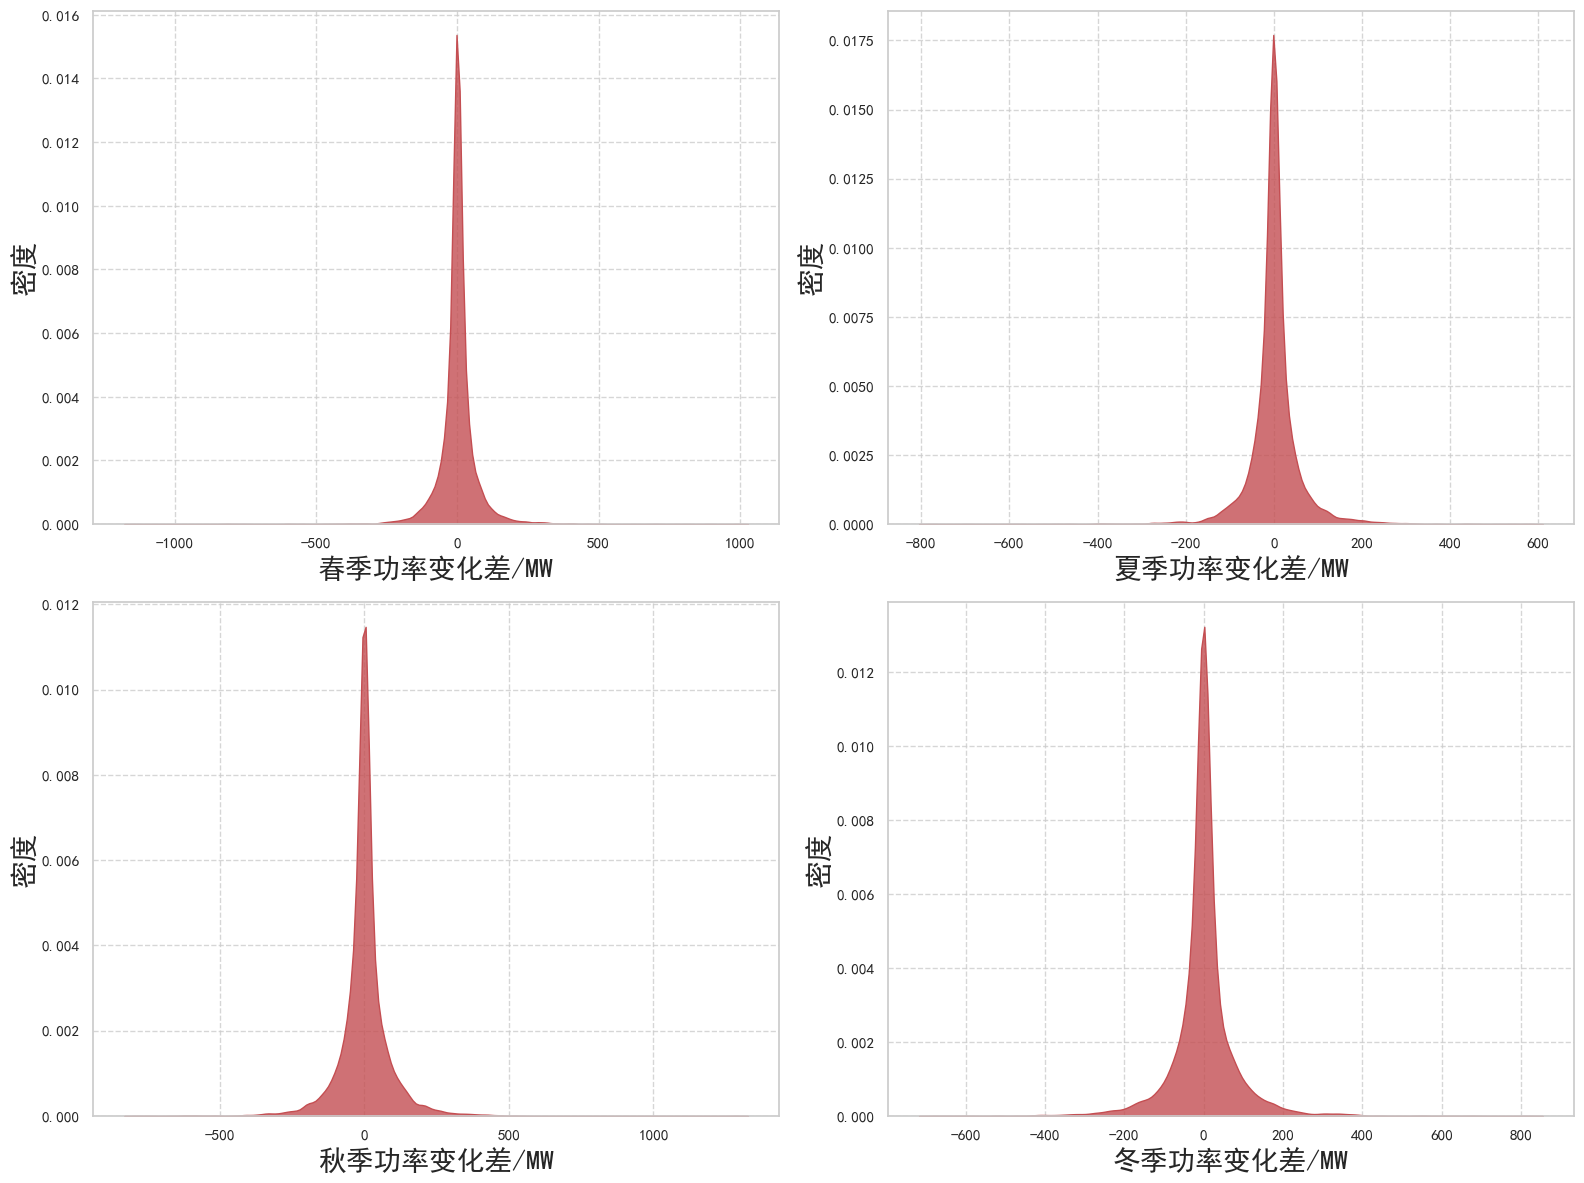

In [41]:
# 为了演示如何绘制4个子图展示不同季节的分布情况，我们首先创建季节列
data_season = data_anly.copy()
# 定义函数以根据月份划分季节
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

def get_season_chinese(season_str):
    if season_str == 'Spring':
        return '春季'
    elif season_str == 'Summer':
        return '夏季'
    elif season_str == 'Autumn':
        return '秋季'
    elif season_str == 'Winter':
        return '冬季'
# 将Datetime列转换为datetime类型
data_season['Datetime'] = pd.to_datetime(data_season['Datetime'])

# 应用函数以创建新的季节列
data_season['Season'] = data_season['Datetime'].dt.month.apply(get_season)

# 设置图形风格
sns.set(style="whitegrid")

# 创建一个 2x2 子图布局
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 定义季节和对应的子图索引
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
axs_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

for season, (i, j) in zip(seasons, axs_indices):
    ax = axs[i, j]
    season_data = data_season[data_season['Season'] == season]['Fluctuation15M']
    season_str = get_season_chinese(season)
    sns.kdeplot(season_data, ax=axs[i, j], fill=True, color="r", alpha=0.8)
    axs[i, j].set_xlabel(f"{season_str}功率变化差/MW",fontsize=20)
    axs[i, j].set_ylabel("密度",fontsize=20)
    ax.grid(True, linestyle='--', linewidth=1, alpha=0.8)

plt.savefig('ch2_fig/分季节分析季节波动值的核密度估计.png')

plt.tight_layout()
plt.show()

In [42]:
# 计算每个季节波动值的峰度和偏度，并以DataFrame形式输出

# 初始化一个空的DataFrame用于存储结果
season_stats = pd.DataFrame(columns=['季节', '峰度', '偏度'])

for season in seasons:
    season_data = data_season[data_season['Season'] == season]['Fluctuation15M']
    season_str = get_season_chinese(season)
    kurtosis = season_data.kurtosis()  # 计算峰度
    skewness = season_data.skew()  # 计算偏度
    season_stats = season_stats.append({'季节': season_str, '峰度': kurtosis, '偏度': skewness}, ignore_index=True)

season_stats.to_csv('ch2_data/分季节分析季节波动值的核密度估计.csv',encoding='utf_8_sig')
season_stats

C:\Users\Great Roy\AppData\Local\Temp\ipykernel_31748\510956378.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  season_stats = season_stats.append({'季节': season_str, '峰度': kurtosis, '偏度': skewness}, ignore_index=True)
C:\Users\Great Roy\AppData\Local\Temp\ipykernel_31748\510956378.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  season_stats = season_stats.append({'季节': season_str, '峰度': kurtosis, '偏度': skewness}, ignore_index=True)
C:\Users\Great Roy\AppData\Local\Temp\ipykernel_31748\510956378.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  season_stats = season_stats.append({'季节': season_str, '峰度': kurtosis, '偏度': skewness}, ignore_index=True)
C:\Users\Great Roy\AppData\Local\Temp\ipykernel_31748\510956378.

,季节,峰度,偏度
0,春季,34.365878,-0.157928
1,夏季,20.937695,-0.336440
2,秋季,14.615567,0.098531
3,冬季,11.667255,0.237298


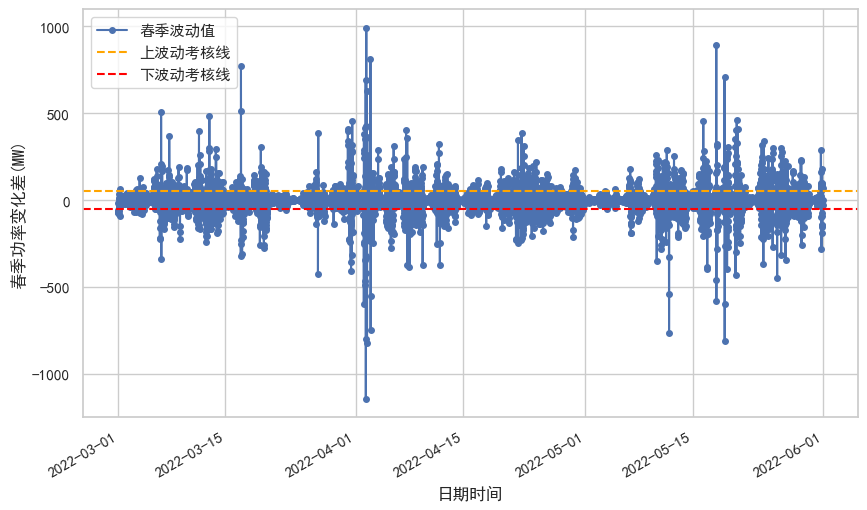

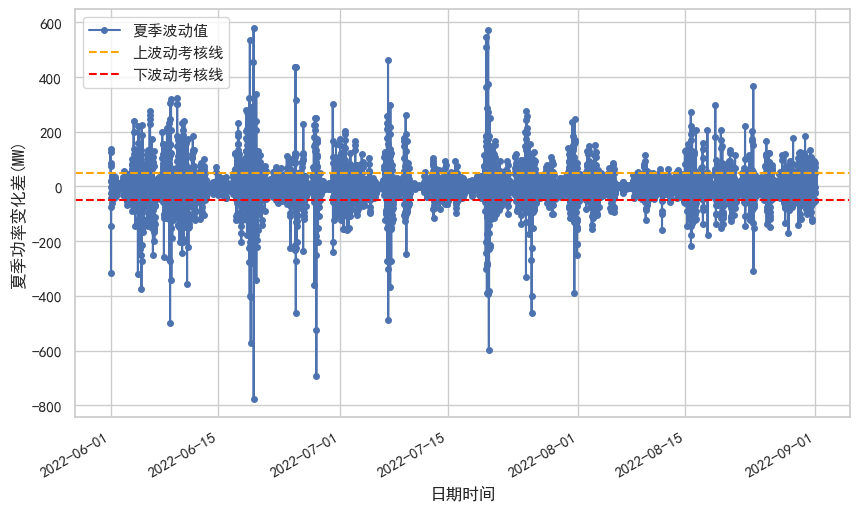

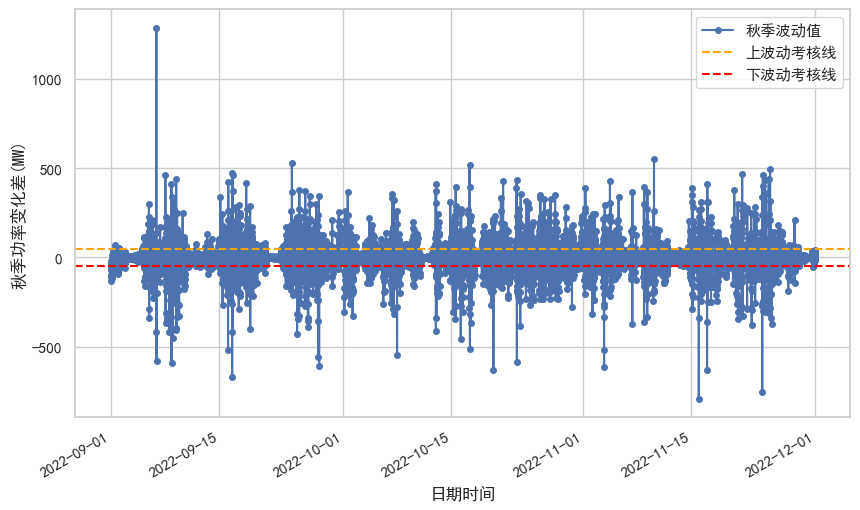

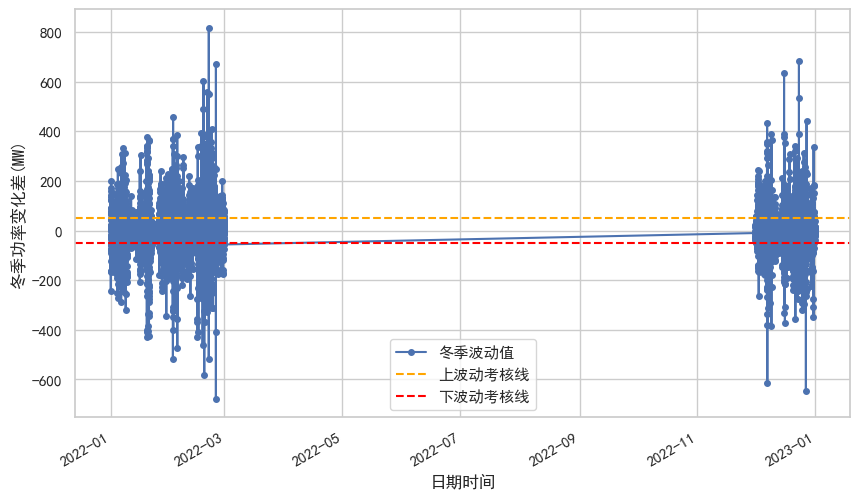

In [43]:
# 调整代码，分别绘制并输出4张图片，每张图片显示一个季节的波动情况和基线

# 重新设置图形风格
sns.set(style="whitegrid")

# 定义季节和数据
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

for season in seasons:
    season_data = data_season[data_season['Season'] == season].sort_values(by='Datetime')  # 确保数据按时间排序
    season_str = get_season_chinese(season)
    # 创建图形
    plt.figure(figsize=(10, 6))
    plt.plot(season_data['Datetime'], season_data['Fluctuation15M'], label=f"{season_str}波动值",marker='o', linestyle='-', markersize=4)
    
    # 添加基线
    plt.axhline(50, color='orange', linestyle='--', label='上波动考核线')
    plt.axhline(-50, color='red', linestyle='--', label='下波动考核线')

    # 设置中文字体和负号显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    # plt.title(f"{season_str}波动情况")
    plt.xlabel("日期时间")
    plt.ylabel(f"{season_str}功率变化差(MW)")
    plt.legend()

    # 设置x轴为日期时间格式
    plt.gca().xaxis_date()
    plt.gcf().autofmt_xdate()  # 自动调整日期显示的格式
    plt.savefig(f'ch2_fig/{season_str}波动性超过考核分析.png')

    # 显示图形
    plt.show()
    


- 画图改成全部中文，波动值要加单位

- 需要添加峰度偏度分析

- 波动值集中分布于-18.870000与17.510000之间

In [44]:
upward_ratio = data_anly['Fluctuation15M'].max()/data_anly['Monitored capacity'].unique()
downward_ratio = -data_anly['Fluctuation15M'].min()/data_anly['Monitored capacity'].unique()

print("向上波动最大达到了风场容量的{0}".format(upward_ratio))
print("向下波动最大达到了风场容量的{0}".format(downward_ratio))


向上波动最大达到了风场容量的[0.56985451]
向下波动最大达到了风场容量的[0.50671576]


# 第二章，对波动进行分类分析

向上统计
- 第一步，统计超过考核的上波动
- 第二步，统计超过考核的上波动的连续波动
- 第三步，统计每天的超过考核的连续波动情况
-  包含几次超过考核的连续波动，连续波动率越限值的求和值，超过考核的连续波动率最大值
- 第四步，分季节统计平均每天多少次超过考核的连续波动，平均每天连续波动率越限值的求和值，超过考核的连续波动率最大值
（分季节的意义，只是为了保证统计量不失普遍性）

## 2.1 向上波动

In [45]:
data_anly_upward = data_anly.copy()
data_anly_upward = data_anly_upward[(data_anly_upward['Fluctuation15M'] >= 0)&(data_anly_upward['above_line']>0)]
data_anly_upward.describe().to_csv('ch2_data/越限的向上波动值的总体描述.csv')
data_anly_upward

,Datetime,Measured & Upscaled,Most recent forecast,Monitored capacity,ShiftMeasured,Fluctuation15M,PredFluctuation15M,ShiftFluctuation15M,abs_Fluctuation15M,above_line
1,2022-01-01 00:15:00,1962.39,1855.50,2254.4,1803.48,158.91,52.02,0.00,158.91,108.91
9,2022-01-01 02:15:00,1362.66,1529.81,2254.4,1295.70,66.96,234.11,15.76,66.96,16.96
10,2022-01-01 02:30:00,1487.22,1481.82,2254.4,1362.66,124.56,119.16,66.96,124.56,74.56
11,2022-01-01 02:45:00,1557.98,1433.83,2254.4,1487.22,70.76,-53.39,124.56,70.76,20.76
13,2022-01-01 03:15:00,1447.08,1416.29,2254.4,1312.72,134.36,103.57,-245.26,134.36,84.36
...,...,...,...,...,...,...,...,...,...,...
34962,2022-12-31 04:30:00,1457.07,1934.68,2254.4,1383.00,74.07,551.68,179.24,74.07,24.07
34963,2022-12-31 04:45:00,1639.72,2004.17,2254.4,1457.07,182.65,547.10,74.07,182.65,132.65
34964,2022-12-31 05:00:00,1977.24,2037.52,2254.4,1639.72,337.52,397.80,182.65,337.52,287.52
34965,2022-12-31 05:15:00,2034.27,2148.42,2254.4,1977.24,57.03,171.18,337.52,57.03,7.03


## 2.2 向下波动

In [46]:
data_anly_downward = data_anly.copy()
data_anly_downward = data_anly_downward[(data_anly_downward['Fluctuation15M'] <= 0)&(data_anly_downward['above_line']>0)]
data_anly_downward.describe().to_csv('ch2_data/越限的向下波动值的总体描述.csv')
data_anly_downward

,Datetime,Measured & Upscaled,Most recent forecast,Monitored capacity,ShiftMeasured,Fluctuation15M,PredFluctuation15M,ShiftFluctuation15M,abs_Fluctuation15M,above_line
2,2022-01-01 00:30:00,1801.63,1823.16,2254.4,1962.39,-160.76,-139.23,158.91,160.76,110.76
4,2022-01-01 01:00:00,1661.57,1779.28,2254.4,1824.41,-162.84,-45.13,22.78,162.84,112.84
5,2022-01-01 01:15:00,1537.71,1743.19,2254.4,1661.57,-123.86,81.62,-162.84,123.86,73.86
6,2022-01-01 01:30:00,1369.23,1681.49,2254.4,1537.71,-168.48,143.78,-123.86,168.48,118.48
7,2022-01-01 01:45:00,1279.94,1635.11,2254.4,1369.23,-89.29,265.88,-168.48,89.29,39.29
...,...,...,...,...,...,...,...,...,...,...
34956,2022-12-31 03:00:00,1986.06,2079.73,2254.4,2071.58,-85.52,8.15,-20.48,85.52,35.52
34957,2022-12-31 03:15:00,1638.46,2030.70,2254.4,1986.06,-347.60,44.64,-85.52,347.60,297.60
34958,2022-12-31 03:30:00,1329.13,1928.68,2254.4,1638.46,-309.33,290.22,-347.60,309.33,259.33
34959,2022-12-31 03:45:00,1053.70,1788.40,2254.4,1329.13,-275.43,459.27,-309.33,275.43,225.43


对数据超出考核范围的进行描述（必要性）50兆瓦

## 2.3 统计连续向上波动

### 连续统计函数

In [47]:
def continuou_fluctuation_analysis(df,mode):
    # 功能描述：分析连续波动的各项指标
    # 函数输入：原始数据集，模式，保存文件夹
    # 函数输出：分析数据集
    df_positive_copy = df.copy()

    if mode == 'positive':
        df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] > 0
        df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] > 50
    elif mode == 'negative':
        df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] < 0
        df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] < -50

    # # 进行绝对值的处理
    # df_positive_copy['is_positive'] = abs(df_positive_copy['is_positive'])
    df_positive_copy['Fluctuation15M'] = abs(df_positive_copy['Fluctuation15M'])
    
    # 检测连续正数序列的开始
    df_positive_copy['new_group'] = df_positive_copy['is_positive_above'] & (df_positive_copy['is_positive_above'] != df_positive_copy['is_positive_above'].shift(1))
    # 为每个连续正数序列分配一个唯一的标识
    df_positive_copy['group_id'] = df_positive_copy['new_group'].cumsum()
    # 仅选取正数进行分组和计数
    positive_sequences = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id').size() # 创造从id到长度的映射
    # 首先对每个连续正数序列进行聚合计算，得到波动总值、平均值和最大值
    grouped_stats = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id')['Fluctuation15M'].agg(
        total_fluctuation='sum',
        average_fluctuation='mean',
        max_fluctuation='max'
    ).reset_index()

    # 将原先计算的序列长度也加入统计表中
    grouped_stats['sequence_length'] = grouped_stats['group_id'].map(positive_sequences)

    # 现在grouped_stats包含了每个连续正数序列的长度、波动总值、平均值和最大值
    # 对这些统计值进行进一步的汇总统计
    summary_stats = grouped_stats.groupby('sequence_length').agg({
        'total_fluctuation': ['sum', 'mean', 'max'],
        'average_fluctuation': ['mean'],
        'max_fluctuation': ['max']
    })
    # 计算各长度连续波动的数量
    sequence_counts = positive_sequences.groupby(positive_sequences).size().reset_index()
    sequence_counts.columns = ['sequence_length', 'count']

    # 合并各项统计数据
    summary_stats = pd.merge(summary_stats, sequence_counts, on='sequence_length', how='left')

    # 重命名列以便更清晰地表示统计结果
    summary_stats.columns = ['sequence_length', 'total_fluctuation_sum', 'total_fluctuation_mean', 'total_fluctuation_max',
                             'average_fluctuation_mean', 'max_fluctuation_max', 'count']
    # # 重命名列以便更清晰地表示统计结果
    # summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
    # summary_stats = summary_stats.reset_index()

    return summary_stats



In [48]:
# 越限的连续波动分析
df_positive_copy = data_anly.copy()
positive_summary_stats = continuou_fluctuation_analysis(df_positive_copy,'positive')
positive_summary_stats.to_csv('ch2_data/连续向下波动功率差统计.csv')
positive_summary_stats

C:\Users\Great Roy\AppData\Local\Temp\ipykernel_31748\3090041095.py:46: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  summary_stats = pd.merge(summary_stats, sequence_counts, on='sequence_length', how='left')


,sequence_length,total_fluctuation_sum,total_fluctuation_mean,total_fluctuation_max,average_fluctuation_mean,max_fluctuation_max,count
0,1,123840.36,96.448879,813.11,96.448879,813.11,1284
1,2,160930.79,244.575669,1421.01,122.287834,1284.68,658
2,3,99085.34,390.099764,1736.38,130.033255,893.29,254
3,4,51795.04,539.531667,1834.09,134.882917,685.36,96
4,5,38787.67,668.752931,1427.74,133.750586,462.51,58
5,6,28475.63,862.897879,1831.46,143.816313,634.12,33
6,7,12489.75,1040.812500,1588.84,148.687500,455.59,12
7,8,8952.18,1119.022500,2001.29,139.877813,437.96,8
8,9,5271.86,1317.965000,1548.50,146.440556,318.55,4
9,10,2320.98,1160.490000,1355.40,116.049000,268.89,2


In [49]:
positive_summary_stats[1:].sum()

sequence_length                 82.000000
total_fluctuation_sum       411213.310000
total_fluctuation_mean       10448.217909
total_fluctuation_max        17848.780000
average_fluctuation_mean      1435.151190
max_fluctuation_max           5869.290000
count                         1127.000000
dtype: float64

In [54]:
positive_draw = positive_summary_stats.copy()

fig = px.pie(positive_draw, values='total_fluctuation_sum', names='sequence_length')
fig.show()

## 2.4 统计连续向下波动

In [ ]:
df_positive_copy = data_anly.copy()
negative_summary_stats = continuou_fluctuation_analysis(df_positive_copy,'negative')
negative_summary_stats.to_csv('ch2_data/连续向下波动功率差统计.csv')
negative_summary_stats

C:\Users\Great Roy\AppData\Local\Temp\ipykernel_31748\3090041095.py:46: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  summary_stats = pd.merge(summary_stats, sequence_counts, on='sequence_length', how='left')


,sequence_length,total_fluctuation_sum,total_fluctuation_mean,total_fluctuation_max,average_fluctuation_mean,max_fluctuation_max,count
0,1,131611.96,98.659640,1142.34,98.659640,1142.34,1334
1,2,154121.15,244.636746,1124.68,122.318373,823.63,630
2,3,87131.12,373.953305,1674.04,124.651102,812.01,233
3,4,64229.07,513.832560,1581.00,128.458140,749.93,125
4,5,34546.17,767.692667,1834.20,153.538533,767.80,45
5,6,18892.05,674.716071,1132.96,112.452679,407.88,28
6,7,8344.77,834.477000,1392.19,119.211000,313.90,10
7,8,8048.34,894.260000,1249.19,111.782500,280.50,9
8,9,4663.92,1165.980000,1525.70,129.553333,249.14,4
9,10,975.61,975.610000,975.61,97.561000,143.98,1


In [ ]:
negative_summary_stats[1:].sum()

sequence_length                 93.000000
total_fluctuation_sum       388487.550000
total_fluctuation_mean       11013.333349
total_fluctuation_max        17334.640000
average_fluctuation_mean      1456.051287
max_fluctuation_max           5335.570000
count                         1090.000000
dtype: float64

In [58]:
negative_draw = negative_summary_stats.copy()

fig = px.pie(negative_draw, values='total_fluctuation_sum', names='sequence_length')
fig.update_layout(
    font=dict(family="SimHei", size=15)
)
fig.show()

# 第三章配置储能

## 能量配置

### 向上

In [ ]:
def cal_total_optimized_energy(series):
    series = np.array(series)
    n = len(series)
    total_energy = 0
    for i in range(n):
        energy = (n - i) * series[i]*0.25
        total_energy += energy
    return round(total_energy,0)

df_positive_copy = data_anly.copy()
mode = 'positive'
if mode == 'positive':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] > 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] > 50
elif mode == 'negative':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] < 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] < -50

# 进行绝对值的处理
df_positive_copy['Fluctuation15M'] = abs(df_positive_copy['Fluctuation15M'])

# 检测连续正数序列的开始
df_positive_copy['new_group'] = df_positive_copy['is_positive_above'] & (df_positive_copy['is_positive_above'] != df_positive_copy['is_positive_above'].shift(1))
# 为每个连续正数序列分配一个唯一的标识
df_positive_copy['group_id'] = df_positive_copy['new_group'].cumsum()
# 仅选取正数进行分组和计数
positive_sequences = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id').size()
# 首先对每个连续正数序列进行聚合计算，得到波动总值、平均值和最大值
grouped_stats = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id',group_keys=True)['above_line'].apply(cal_total_optimized_energy).reset_index()
# grouped_stats_list = list(grouped_stats)
# for i in grouped_stats_list[:50]:
#     print(i)
grouped_stats

# 将原先计算的序列长度也加入统计表中
grouped_stats['sequence_length'] = grouped_stats['group_id'].map(positive_sequences)
optizmized_continuous_positive_energy = grouped_stats.groupby('sequence_length').agg({'above_line':[np.mean,np.max,lambda x:np.percentile(x,75)]})

optizmized_continuous_positive_energy.to_csv('ch2_data/优化连续向上越限波动段至考核边界所需能量统计.csv')


### 向下

In [ ]:


df_positive_copy = data_anly.copy()
mode = 'negative'
if mode == 'positive':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] > 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] > 50
elif mode == 'negative':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] < 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] < -50

# 进行绝对值的处理
df_positive_copy['Fluctuation15M'] = abs(df_positive_copy['Fluctuation15M'])

# 检测连续正数序列的开始
df_positive_copy['new_group'] = df_positive_copy['is_positive_above'] & (df_positive_copy['is_positive_above'] != df_positive_copy['is_positive_above'].shift(1))
# 为每个连续正数序列分配一个唯一的标识
df_positive_copy['group_id'] = df_positive_copy['new_group'].cumsum()
# 仅选取正数进行分组和计数
positive_sequences = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id').size()
# 首先对每个连续正数序列进行聚合计算，得到波动总值、平均值和最大值
grouped_stats = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id',group_keys=True)['above_line'].apply(cal_total_optimized_energy).reset_index()
# grouped_stats_list = list(grouped_stats)
# for i in grouped_stats_list[:50]:
#     print(i)
grouped_stats

# 将原先计算的序列长度也加入统计表中
grouped_stats['sequence_length'] = grouped_stats['group_id'].map(positive_sequences)
optizmized_continuous_negative_energy = grouped_stats.groupby('sequence_length').agg({'above_line':[np.mean,np.max,lambda x:np.percentile(x,75)]})

optizmized_continuous_negative_energy.to_csv('ch2_data/优化连续向下越限波动段至考核边界所需能量统计.csv')


## 功率

### 向上

In [ ]:
def cal_total_optimized_power(series):
    series = np.array(series)
    n = len(series)
    total_power = 0
    last_power = 0
    for i in range(n):
        power = series[i]
        last_power += power # 每一个越限波动相加
    return last_power

df_positive_copy = data_anly.copy()
mode = 'positive'
if mode == 'positive':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] > 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] > 50
elif mode == 'negative':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] < 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] < -50

# 进行绝对值的处理
df_positive_copy['Fluctuation15M'] = abs(df_positive_copy['Fluctuation15M'])

# 检测连续正数序列的开始
df_positive_copy['new_group'] = df_positive_copy['is_positive_above'] & (df_positive_copy['is_positive_above'] != df_positive_copy['is_positive_above'].shift(1))
# 为每个连续正数序列分配一个唯一的标识
df_positive_copy['group_id'] = df_positive_copy['new_group'].cumsum()
# 仅选取正数进行分组和计数
positive_sequences = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id').size()
# 首先对每个连续正数序列进行聚合计算，得到波动总值、平均值和最大值
grouped_stats = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id',group_keys=True)['above_line'].apply(cal_total_optimized_power).reset_index()
# grouped_stats_list = list(grouped_stats)
# for i in grouped_stats_list[:50]:
#     print(i)
grouped_stats

# 将原先计算的序列长度也加入统计表中
grouped_stats['sequence_length'] = grouped_stats['group_id'].map(positive_sequences)
optizmized_continuous_positive_power = grouped_stats.groupby('sequence_length').agg({'above_line':[np.mean,np.max,lambda x:np.percentile(x,75)]})

optizmized_continuous_positive_power.to_csv('ch2_data/优化连续向上越限波动段至考核边界的最大出力功率.csv')

### 向下

In [ ]:

df_positive_copy = data_anly.copy()
mode = 'negative'
if mode == 'positive':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] > 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] > 50
elif mode == 'negative':
    df_positive_copy['is_positive'] = df_positive_copy['Fluctuation15M'] < 0
    df_positive_copy['is_positive_above'] = df_positive_copy['Fluctuation15M'] < -50

# 进行绝对值的处理
df_positive_copy['Fluctuation15M'] = abs(df_positive_copy['Fluctuation15M'])

# 检测连续正数序列的开始
df_positive_copy['new_group'] = df_positive_copy['is_positive_above'] & (df_positive_copy['is_positive_above'] != df_positive_copy['is_positive_above'].shift(1))
# 为每个连续正数序列分配一个唯一的标识
df_positive_copy['group_id'] = df_positive_copy['new_group'].cumsum()
# 仅选取正数进行分组和计数
positive_sequences = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id').size()
# 首先对每个连续正数序列进行聚合计算，得到波动总值、平均值和最大值
grouped_stats = df_positive_copy[df_positive_copy['is_positive_above']].groupby('group_id',group_keys=True)['above_line'].apply(cal_total_optimized_power).reset_index()
# grouped_stats_list = list(grouped_stats)
# for i in grouped_stats_list[:50]:
#     print(i)
grouped_stats

# 将原先计算的序列长度也加入统计表中
grouped_stats['sequence_length'] = grouped_stats['group_id'].map(positive_sequences)
optizmized_continuous_negative_power = grouped_stats.groupby('sequence_length').agg({'above_line':[np.mean,np.max,lambda x:np.percentile(x,75)]})

optizmized_continuous_negative_power.to_csv('ch2_data/优化连续向下越限波动段至考核边界的最大出力功率.csv')